In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = "/content/drive/My Drive/Colab Notebooks/MSc_project/test/npy/train_0/"

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
import sys
import os
print(os.listdir(path))

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from keras.utils import np_utils
from keras.models import Model, load_model
from keras.layers import Input, concatenate, Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
from keras.layers.core import Lambda, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

np.set_printoptions(threshold=np.inf)

['images', 'masks']


Using TensorFlow backend.


**Visualizing the training images**

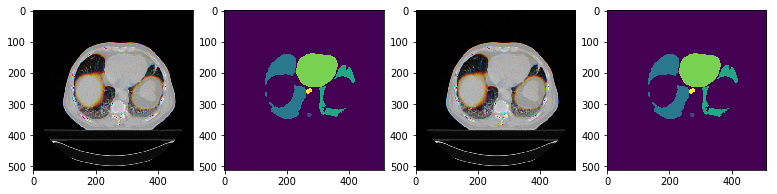

In [0]:
# path_train='../input/train/train/'
ids= ['ADE_train_00001004','ADE_train_00001006']
plt.figure(figsize=(20,10))
# for j, img_name in enumerate(ids):
for j, img_name in enumerate(ids):
    q = j+1
    j = j+1
#     img = load_img(path+'images/' + str(45) + '.jpg')
#     img_mask = load_img(path+'masks/' + str(45) +'.png')
    img = np.load(path+'images/' + str(45) + '_image.npy').transpose(1, 2, 0)
    img_mask = np.load(path+'masks/' + str(45) +'_mask.npy')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

**Finding train ids to use that id for the images and its mask simultaneously while training**

In [0]:
import re
train_ids = next(os.walk(path+"images"))[2]
print(len(train_ids))
new_train_ids=[]
for item in train_ids:
    new_train_ids.append(' '.join(re.findall(r'\d+', item)))
print(new_train_ids)

138
['38', '14', '119', '11', '49', '85', '28', '70', '137', '138', '3', '51', '62', '43', '42', '39', '64', '112', '132', '117', '2', '118', '131', '79', '57', '127', '120', '99', '27', '44', '77', '87', '45', '135', '36', '116', '40', '82', '68', '101', '86', '33', '63', '59', '66', '13', '23', '115', '130', '58', '6', '67', '90', '110', '94', '69', '46', '7', '122', '83', '95', '125', '91', '76', '97', '121', '18', '8', '50', '88', '31', '29', '78', '129', '22', '102', '53', '32', '19', '105', '30', '15', '80', '41', '60', '108', '100', '93', '20', '52', '106', '81', '10', '34', '126', '123', '56', '47', '37', '4', '111', '103', '128', '133', '74', '72', '12', '98', '9', '55', '134', '54', '16', '75', '136', '35', '124', '73', '26', '92', '17', '5', '104', '109', '107', '24', '48', '61', '21', '96', '25', '89', '65', '114', '71', '84', '113', '1']


**Attributes of training images and its Mask images**
Here n_labels=6 denotes that there are 6 classes in mask images

In [0]:
input_shape=(512, 512, 3)
im_width = input_shape[0]
im_height = input_shape[1]
im_chan = input_shape[2]
n_labels = 6

**Getting and resizing training images and masks **


(512, 512, 3)


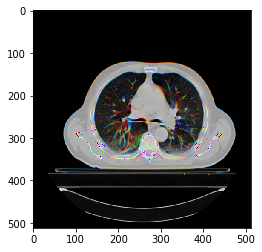

(138, 512, 512)
(138, 512, 512, 3)
(138, 512, 512, 6)
Done!


In [0]:
X_train = np.zeros((len(new_train_ids), im_height, im_width, 3), dtype=np.uint8)
Y_train = np.zeros((len(new_train_ids), im_height, im_width), dtype=np.uint8)
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(new_train_ids), total=len(new_train_ids)):
    img = np.load(path + 'images/' + id_+'_image.npy').transpose(1, 2, 0)
    x = img[:,:,:]
    x = resize(x, (512, 512, 3), mode='constant', preserve_range=True)
    X_train[n] = x
    
    mask = (np.load(path + 'masks/' + id_+'_mask.npy'))
    Y_train[n] = resize(mask, (512, 512), mode='constant', preserve_range=True)
#     Y_train[n] = mask 

# test
print(X_train[7].shape)
plt.imshow(X_train[7])
plt.show()
# test

print(Y_train.shape)

Y_train = np_utils.to_categorical(Y_train, n_labels) #np_utils.to_categorical for one hot encoding to no of label 
# print(Y_train[67])
print(X_train.shape)
print(Y_train.shape)
print('Done!')

(138, 512, 512, 6)
Y example shape (512, 512, 6)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



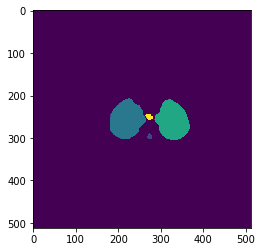

In [0]:
print(Y_train.shape)
# results.history['mean_iou']
print("Y example shape", Y_train[60].shape)
print(Y_train[60])
# decode function
decode = np.argmax(Y_train[60], axis=-1)
# print("decode ex:", decode)
plt.imshow(decode)


In [0]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_sessiomean_ioun().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)


In [0]:
# define DICE loss
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32') 
    return Ncl-T

In [0]:
def generalized_dice_loss_w(y_true, y_pred): 
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    Ncl = y_pred.shape[-1]
    w = K.zeros((Ncl,))
    # w = K.sum(y_true, (0,1,2))
    # w = K.sum(w)/(w + 1.0)
    # w = w/K.sum(w)
    alpha = 0.5
    w = np.array([0, 0.25,  0.25,  0.2,  0.1, 0.1])*(1-alpha)

    numerator = y_true*y_pred
    numerator = w*K.sum(numerator, (0,1,2))
    denominator = y_true+y_pred+1e-5
    denominator = K.sum(denominator, (0,1,2))
    gen_dice_coef = numerator/denominator
    gen_dice_coef = K.sum(gen_dice_coef)

    return 1-2*gen_dice_coef

In [0]:
from keras.layers.normalization import BatchNormalization
input_shape=(512, 512, 3)
n_labels=6
kernel=3
# Build U-Net model
inputs = Input((input_shape))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2),kernel_initializer='he_normal', padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu',kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(n_labels, (1, 1), activation='softmax') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[generalized_dice_loss_w])
model.summary()


W0808 13:55:35.697818 139836782249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0808 13:55:35.741490 139836782249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0808 13:55:35.753700 139836782249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0808 13:55:35.791769 139836782249856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0808 13:55:36.048649 139836782249856 deprec

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 512, 512, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 512, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 512, 512, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [0]:
path = "/content/drive/My Drive/Colab Notebooks/MSc_project/test/npy/train_0/"
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/MSc_project/test/model-segmentation.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=32, epochs=100, 
                    callbacks=[earlystopper, checkpointer])

model.save('/content/drive/My Drive/Colab Notebooks/MSc_project/test/model-segmentation.h5')

W0808 13:55:36.236907 139836782249856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 124 samples, validate on 14 samples
Epoch 1/100
124/124 [==============================] - 26s 207ms/step - loss: 1.7552 - generalized_dice_loss_w: 0.9926 - val_loss: 1.3828 - val_generalized_dice_loss_w: 0.9928

Epoch 00001: val_loss improved from inf to 1.38277, saving model to /content/drive/My Drive/Colab Notebooks/MSc_project/test/model-segmentation.h5
Epoch 2/100
124/124 [==============================] - 4s 31ms/step - loss: 1.2003 - generalized_dice_loss_w: 0.9948 - val_loss: 0.9126 - val_generalized_dice_loss_w: 0.9942

Epoch 00002: val_loss improved from 1.38277 to 0.91262, saving model to /content/drive/My Drive/Colab Notebooks/MSc_project/test/model-segmentation.h5
Epoch 3/100
124/124 [==============================] - 4s 30ms/step - loss: 0.6784 - generalized_dice_loss_w: 0.9924 - val_loss: 0.3721 - val_generalized_dice_loss_w: 0.9876

Epoch 00003: val_loss improved from 0.91262 to 0.37212, saving model to /content/drive/My Drive/Colab Notebooks/MSc_project/test/m

test img shape (1, 512, 512, 6)
test out shap:  (512, 512, 6)
decode ex: (512, 512)


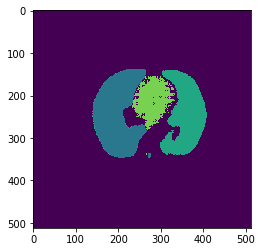

In [0]:

dependencies = {
    'generalized_dice_loss_w': generalized_dice_loss_w
}
model = load_model('/content/drive/My Drive/Colab Notebooks/MSc_project/test/model-segmentation.h5', custom_objects=dependencies)

test_example_path = "/content/drive/My Drive/Colab Notebooks/MSc_project/test/npy/train_0/images/60_image.npy"

test_num = 1
X_test = np.zeros((test_num, im_height, im_width, 3), dtype=np.uint8)
# mask = (np.load(path + 'masks/' + id_+'_mask.npy'))

for i in range(test_num):
    test_ex = np.load(test_example_path).transpose(1, 2, 0)
    x = test_ex[:,:,:]
    x = resize(x, (512, 512, 3), mode='constant', preserve_range=True)
    X_test[i] = x
    # print(x[222][222])

# plt.imshow(X_test[0])
# plt.show

# img_1 = np.expand_dims(x, axis=0)
# print('img_1: ',img_1.shape)

# print('after expand: ',img_1[0][222][222])

test_img = model.predict(X_test, batch_size = 32)
print('test img shape', test_img.shape)

test_out = test_img[0,:,:,:]
# print('test out shap: ',test_out)
print('test out shap: ',test_out.shape)
test_decode = np.argmax(test_out, axis=-1)
# print("decode ex:", test_decode)
print("decode ex:", test_decode.shape)
plt.imshow(test_decode)